# Final Métodos numéricos, cátedra Pablo Dimitruk

El objetivo de este trabajo es estudiar el proceso de decoherencia para una partícula de masa $m$ utilizando el modelo de Caldeira-Leggett [1]. Para esto resolveremos numéricamente la ecuación maestra y obtendremos la evolución temporal de una partícula en un entorno bosónico. La partícula iniciará en un estado superposición de dos paquetes gaussianos (lo que habitualmente se llama un estado gato de Schrödinger) y esperamos ver cómo los elementos no diagonales de la matriz densidad desaparecen por efecto de la decoherencia, resultando en un estado final clásico (mezcla estadística de dos paquetes gaussianos). 

Resolveremos el problema con diferentes métodos y analizaremos sus errores numéricos. Como integradores temporales consideramos el método de Euler y el método Runge-Kutta 4. Para las derivadas espaciales consideraremos primero diferencias finitas centradas, y luego un método pseudo espectral. 

La ecuación que queremos resolver es la siguiente:

$\frac{d}{dt}\rho_\mathcal{S}(x,x^{'},t)\,=\,\left[\frac{i}{2m}\left(\frac{\partial^2}{\partial x^2} - \frac{\partial^2}{\partial {x^{'}}^2}\right) - \gamma\,(x-x^{'})\left(\frac{\partial}{\partial x}\,-\,\frac{\partial}{\partial x^{'}}\right)\,-\,2m\gamma k_BT\,(x-x^{'})^2\right]\,\rho_\mathcal{S}(x,x^{'},t)$

donde $\rho_\mathcal{S}(x,x^{'}, t)$ es el operador densidad del sistema a tiempo $t$.

La condición inicial del sistema es: AGREGAR



[1] Caldeira, A. O., & Leggett, A. J. (1981). Influence of dissipation on quantum tunneling in macroscopic systems. Physical review letters, 46(4), 211.

## Resolución numérica del problema

In [196]:
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
from scipy.sparse import diags
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [201]:
#### Parameters
m = 1
gamma = 1e-2
T = 10
L = 4 # Box side
var = 1 / (2*m*T)**0.5 # Gaussian variance
dist = 1 # Separation between gaussians

### Initial state:
def init_state(var, dist, L, Nx, Ny) -> np.ndarray:
    rho = np.zeros([Nx, Ny], dtype=np.complex128)
    x = np.linspace(0, L, Nx)
    y = np.linspace(0, L, Ny)
    Y, X = np.meshgrid(x, y)
    rho = ((np.exp(-(X - L/2.0 + dist/2)**2/(2*var**2)) +
            np.exp(-(X - L/2.0 - dist/2)**2/(2*var**2))) * 
           (np.exp(-(Y - L/2.0 + dist/2)**2/(2*var**2)) +
            np.exp(-(Y - L/2.0 - dist/2)**2/(2*var**2))))
    return rho / rho.trace()

def final_state(var, dist, L, Nx, Ny):
    rho = np.zeros([Nx, Ny], dtype=np.complex128)
    x = np.linspace(0, L, Nx)
    y = np.linspace(0, L, Ny)
    Y, X = np.meshgrid(x, y)
    rho = (np.exp(-(X - L/2.0 + dist/2)**2/(2*var**2)) *
           np.exp(-(Y - L/2.0 + dist/2)**2/(2*var**2)) + 
           np.exp(-(X - L/2.0 - dist/2)**2/(2*var**2)) *      
           np.exp(-(Y - L/2.0 - dist/2)**2/(2*var**2)))
    return rho / rho.trace()

In [234]:
N = 8
D = diags([2/3 ,-1/12*np.ones(2), 1/12*np.ones(N-2), -2/3*np.ones(N-1), 2/3*np.ones(N-1), -1/12*np.ones(N-1), 1/12*np.ones(2), -2/3],
          offsets=[-N+1, -N+2, -2,-1,1,2, N-2, N-1])
D.todense()

matrix([[ 0.        ,  0.66666667, -0.08333333,  0.        ,  0.        ,
          0.        ,  0.08333333, -0.66666667],
        [-0.66666667,  0.        ,  0.66666667, -0.08333333,  0.        ,
          0.        ,  0.        ,  0.08333333],
        [ 0.08333333, -0.66666667,  0.        ,  0.66666667, -0.08333333,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.08333333, -0.66666667,  0.        ,  0.66666667,
         -0.08333333,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.08333333, -0.66666667,  0.        ,
          0.66666667, -0.08333333,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.08333333, -0.66666667,
          0.        ,  0.66666667, -0.08333333],
        [-0.08333333,  0.        ,  0.        ,  0.        ,  0.08333333,
         -0.66666667,  0.        ,  0.66666667],
        [ 0.66666667, -0.08333333,  0.        ,  0.        ,  0.        ,
          0.08333333, -0.66666667,  0.        ]])

In [239]:

def diff(func, d, N, order=1, axis=0, method='findiff'):
    """
    Calculates partial derivatives of a 1D or 2D function.
    inputs:
        - func: funtion to calculate the partial derivatives of (array).
        - d: differential (float)
        - N: grid points on the direction of differentiation (int).
        - order: order of the derivative (int).
        - axis: direction of derivative (axis=0: dx, axis=1: dy).
        -method: 'findif': finite differences; 'spectral': fourier.
    return:
        partial derivative of func (array with the same shape of func).
    """
    if method == 'findiff':
        if order == 1:
            #D = diags([-0.5*np.ones(N-1), 0.5*np.ones(N-1), -0.5, 0.5], offsets=[-1,1, N-1, -N+1])
            D = diags([2/3 ,-1/12*np.ones(2), 1/12*np.ones(N-2), -2/3*np.ones(N-1), 2/3*np.ones(N-1), -1/12*np.ones(N-1), 1/12*np.ones(2), -2/3],
          offsets=[-N+1, -N+2, -2,-1,1,2, N-2, N-1])

            D /= d
            if axis == 0:
                return D @ func
            elif axis == 1:
                return func @ D.T
        if order == 2:
            D = diags([-2*np.ones(N), np.ones(N-1), np.ones(N-1), 1, 1], offsets = [0,1,-1, N-1, -N+1])
            D /= d**2
            if axis == 0:
                return D @ func
                Df[0,:] = np.zeros(N)
            elif axis == 1:
                return func @ D.T
                
    elif method == 'spectral':
        from numpy.fft import fftn, ifftn, fftfreq 
        funcFFT = fftn(func)
        if order == 1:
            if axis == 0:
                kx = 2j*np.pi*fftfreq(N, d=d)
                kx = kx * (abs(kx) < 3/2 * abs(max(kx)))
                dfunc = np.real((ifftn(kx*funcFFT)))
                return dfunc
        if order == 2:
            if axis == 0:
                kx = 2j*np.pi*fftfreq(N, d=d)
                kx = kx * (abs(kx) < 3/2 * abs(max(kx)))
                dfunc = np.real((ifftn(kx**2 * funcFFT)))
                return dfunc

In [203]:
### Definimos las funciones para calcular la evolucion temporal 
### con los metodos de Euler y RK4

def euler(rho, dt, Nx, Ny):
    x, dx = np.linspace(0, L, Nx, retstep=True)
    y, dy = np.linspace(0, L, Ny, retstep=True)
    Y, X = np.meshgrid(x, y)
    K1 = (1j/(2*m) * (diff(rho, dx, Nx, order=2, axis=0) - diff(rho, dy, Ny, order=2, axis=1)) - 
           gamma * (X - Y) * (diff(rho, dx, Nx, order=1, axis=0) - diff(rho, dy, Ny, order=1, axis=1)) - 
           2 * m * gamma * T * (X - Y)**2 * rho)
    rho[1:-1, 1:-1] = rho[1:-1, 1:-1] + dt*K1[1:-1, 1:-1]
    return rho


def RK2(rho, dt, Nx, Ny):
    x, dx = np.linspace(0, L, Nx, retstep=True)
    y, dy = np.linspace(0, L, Ny, retstep=True)
    Y, X = np.meshgrid(x, y)
    K1 = (1j/(2*m) * (diff(rho, dx, Nx, order=2, axis=0) - diff(rho, dy, Ny, order=2, axis=1)) - 
           gamma * (X - Y) * (diff(rho, dx, Nx, order=1, axis=0) - diff(rho, dy, Ny, order=1, axis=1)) - 
           2 * m * gamma * T * (X - Y)**2 * rho)
    rho_aux = rho
    rho_aux[1:-1, 1:-1] = rho_aux[1:-1, 1:-1] + dt*K1[1:-1, 1:-1]
    K2 = (1j/(2*m) * (diff(rho_aux, dx, Nx, order=2, axis=0) - diff(rho_aux, dy, Ny, order=2, axis=1)) - 
           gamma * (X - Y) * (diff(rho_aux, dx, Nx, order=1, axis=0) - diff(rho_aux, dy, Ny, order=1, axis=1)) - 
           2 * m * gamma * T * (X - Y)**2 * rho_aux)
    rho[1:-1, 1:-1] = rho[1:-1, 1:-1] + 0.5 * dt * (K1[1:-1, 1:-1] + K2[1:-1, 1:-1])
    return rho

In [228]:
### Benchmark steady state
tf = 50
Nt = 100000
t, dt = np.linspace(0, tf, Nt, retstep=True)
N = 1024
x, dx = np.linspace(0, L, N, retstep=True)
y, dy = np.linspace(0, L, N, retstep=True)
Y, X = np.meshgrid(x, y)

state = init_state(var, dist, L, N, N)
sol = final_state(var, dist, L, N, N)
err = []
for i in tqdm(range(Nt)):
    state = RK2(state, dt, N, N)
    err.append(np.max(np.abs(state-sol)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [1:32:34<00:00, 18.00it/s]


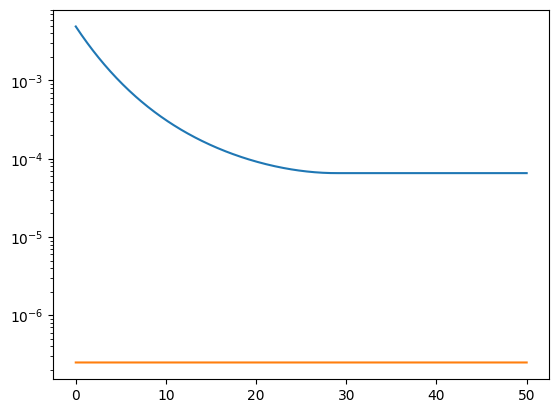

In [229]:
plt.plot(t, err)
plt.plot(t, np.ones(Nt) * dt**2)
plt.yscale('log')

In [173]:
tf = 15
Nts = [500, 1000, 10000]
N = 1024
x, dx = np.linspace(0, L, N, retstep=True)
y, dy = np.linspace(0, L, N, retstep=True)
Y, X = np.meshgrid(x, y)

err = []
d = []

for Nt in Nts:
    t, dt = np.linspace(0, tf, Nt, retstep=True)
    state = init_state(var, dist, L, N, N)
    for i in tqdm(range(Nt)):
        state = RK2(state, dt, N, N)
    d.append(dt)
    err.append(np.max(np.abs(state-benchmark_state)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:30<00:00, 19.60it/s]


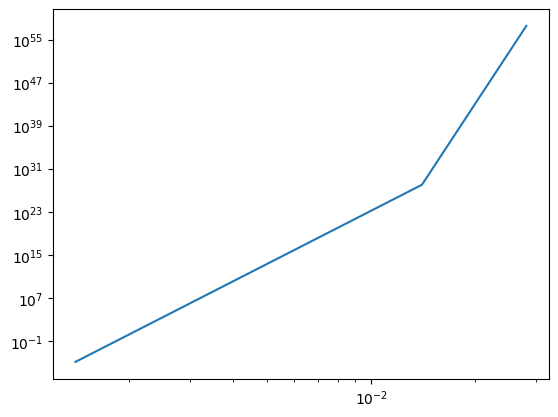

In [174]:
d = np.array(d)
err = np.array(err)
plt.plot(d, err)
plt.xscale('log')
plt.yscale('log')

### Test diff

Chequeamos que las derivadas con diferencias finitas funcionen bien. En particular nos fijamos que el error vaya como $dx_i**2$, ya que es la precisio

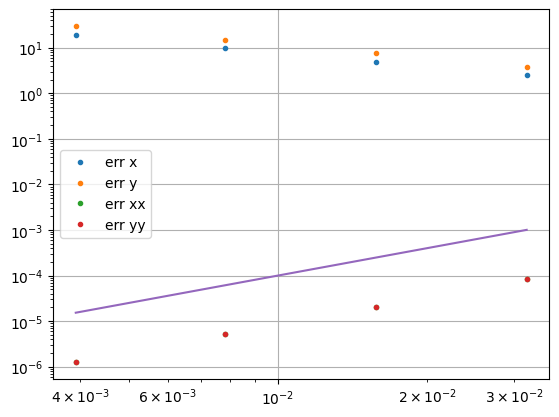

In [240]:
L = 2
Ns = [64, 128, 256, 512]
errx = []
erry = []
errxx = []
erryy = []
d = []
for N in Ns:
    x, dx = np.linspace(0, L, N, retstep = True)
    y, dy = np.linspace(0, L, N, retstep = True)
    Y, X = np.meshgrid(x, y)
    f = np.sin(X)*np.cos(Y)
    dxf = diff(f, dx, N, order=1, axis=0, method='findiff')
    dyf = diff(f, dx, N, order=1, axis=1, method='findiff')
    dxxf = diff(f, dx, N, order=2, axis=0, method='findiff')
    dyyf = diff(f, dx, N, order=2, axis=1, method='findiff')
    dxf_true = np.cos(X)*np.cos(Y)
    dyf_true = -np.sin(X)*np.sin(Y)
    dxxf_true = -np.sin(X)*np.cos(Y)
    dyyf_true = -np.sin(X)*np.cos(Y)
    errx.append(np.max(np.abs(dxf[1:-1, 1:-1] - dxf_true[1:-1, 1:-1])))
    erry.append(np.max(np.abs(dyf[1:-1, 1:-1] - dyf_true[1:-1, 1:-1])))
    errxx.append(np.max(np.abs(dxxf[1:-1, 1:-1] - dxxf_true[1:-1, 1:-1])))
    erryy.append(np.max(np.abs(dyyf[1:-1, 1:-1] - dyyf_true[1:-1, 1:-1])))
    d.append(dx)
d = np.array(d)
plt.plot(d, errx, '.', label='err x')
plt.plot(d, erry, '.', label='err y')
plt.plot(d, errxx, '.', label='err xx')
plt.plot(d, erryy, '.', label='err yy')
plt.plot(d, d**2)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid()